### Purpose of this task
is to estimate an usplift/downlift (if detected), by performing statistical testing over a given data source, to compare Variant versus Control in the current feature implementation.

### What is available
Swimlanes is a widget on a listing page that recommends restaurants atop the normal list of **all restaurants** available below. 

The widget can come in different configurations:
 - "Reorder from the restaurants you love""
 - "Discover new"
 - "Fast delivery"
 -  etc.
 
 <img src="swimlanes.png"> 




For the sake of example we are testing Control (no swimlanes widget) vs. Variant ("New restaurants") 
After users click on the swimlanes tile, they are being redirected to the restaurant page with the menu of items available to order.


Tested timeframe 01 June - 30 June


### We are interested in such metrics:

- Comparison of conversion rate in session (CVR) for the users that had and did not have swimlanes widget
- Microconversion (mOCVR2) that is defined as users' path in the funnel --> "list" page to "restaurant details page" (that shows how often users proceed to the next step on a platform)

### Task
Perform statistical testing and answer such questions:

- Does Variant have *significant* increase/decrease in the metrics we want to test over the Control?
- Are there any differences between the segments? (platform)
- What is the p-value for experiment runtime and does it maintain the same dynamic over the reported timeframe?
- What is the relative uplift/downlift (in %) for the Variant when compared to Control?
- Calculate the standard deviation for this dataset





In [11]:
import pandas as pd
df = pd.read_csv("/Users/mingxuan/Desktop/fp/part3/swimlanes.py")
df.head()

,date,platform,variant,experiment_name,mOCVR2,orders,sessions
0,2019-06-28,Android,Control,swimlanes,36.084795,73043,466229
1,2019-06-28,Android,Variant,swimlanes,36.094200,73104,466516
2,2019-06-28,iOS,Variant,swimlanes,33.755615,134223,632095
3,2019-06-19,Android,Control,swimlanes,36.273787,64958,379314
4,2019-06-19,iOS,Variant,swimlanes,35.146441,119996,506810


### Variant group saw a 3.2% uplift over Control

In [18]:
# Aggregate metrics - Control & Variant of CVR & mOCVR2
control_variant = df[["platform", "variant", "mOCVR2","orders", "sessions"]]. groupby(["variant"]).sum()
control_variant["no_orders"] = control_variant["sessions"] - control_variant["orders"]
control_variant["conversion"] = control_variant["orders"] / control_variant["sessions"]
control_variant

,mOCVR2,orders,sessions,no_orders,conversion
variant,,,,,
Control,880.180409,1570907,9744942,8174035,0.161202
Variant,1737.754868,4453260,23025507,18572247,0.193406


## 1. Does Variant have *significant* increase/decrease in the metrics we want to test over the Control?
### Hypothesis
#### H0: The conversion rate for both Control and Variant groups are the same 
#### H1: The conversion rate of Variant group is higher than Control group

#### Assumptions
- Outcome of each session is binary (Visitor can either convert or not convert within each session)
- Conversions follow a normally distribution
- Since sample size is large, we will use a Z-test

#### Calculating Z score
- First obtain conversion rate for each group `conversion = orders / sessions`
- Use a blended conversion rate `p_hat` to estimate variance 
- Use `sessions` as sample size

Standard deviation: 0.00014802831135076955
Z-score: 217.54770783688582
p-value: 0.0


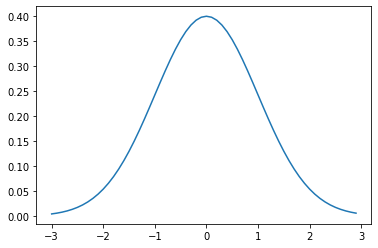

In [19]:
import numpy as np
from scipy.stats import norm

p_hat_control = control_variant.loc["Control"]["conversion"]
p_hat_variant = control_variant.loc["Variant"]["conversion"]

# Blended conversion rates
p_hat = sum(control_variant["orders"]) / sum(control_variant["sessions"])

n_control = control_variant.loc["Control"]["sessions"]
n_variant = control_variant.loc["Variant"]["sessions"]

stdev = np.sqrt( (p_hat * (1 - p_hat) * ( (1 / control_variant.loc["Control"]["sessions"]) + (1 / control_variant.loc["Variant"]["sessions"]))))

Z = (p_hat_variant - p_hat_control) / stdev
pvalue = norm.sf(Z)

print("Standard deviation: {}\nZ-score: {}\np-value: {}".format(stdev, Z, pvalue))

import matplotlib.pyplot as plt

z = np.arange(-3, 3, 0.1)
plt.plot(z, norm.pdf(z))
plt.fill_between(z[z>Z], norm.pdf(z[z>Z]))
plt.show()

#### We reject H0 at 5% significance

### Does the p-value maintain the same dynamic over the reported timeframe?

#### Notes 
- Loop through timeframe dynamically to obtain p values 


In [22]:
"""
Loop through dates to obtain p values of 1 & 2
"""

# Convert date column of df to datetime format
df["date"] = pd.to_datetime(df["date"])

for date in np.sort(df.date.unique()):
    
    temp_df = df[df.date <= date]
    temp_control_variant = temp_df[["platform", "variant", "mOCVR2","orders", "sessions"]]. groupby(["variant"]).sum()
    temp_control_variant["conversion"] = temp_control_variant["orders"] / temp_control_variant["sessions"]
    

    temp_p_hat_control = temp_control_variant.loc["Control"]["conversion"]
    temp_p_hat_variant = temp_control_variant.loc["Variant"]["conversion"]

    temp_p_hat = sum(temp_control_variant["orders"]) / sum(temp_control_variant["sessions"])

    temp_n_control = temp_control_variant.loc["Control"]["sessions"]
    temp_n_variant = temp_control_variant.loc["Variant"]["sessions"]

    temp_Z = (temp_p_hat_variant - temp_p_hat_control) / np.sqrt( (temp_p_hat * (1 - temp_p_hat) * (1 / temp_control_variant.loc["Control"]["sessions"] + 1 / temp_control_variant.loc["Variant"]["sessions"])))

    temp_pvalue = norm.sf(temp_Z)
    print("Dynamic time frame: {} - {}".format(min(temp_df.date) , max(temp_df.date)))
    print("Z-score: {}\np-value: {}".format(temp_Z,temp_pvalue))

Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-01 00:00:00
Z-score: 41.14184249604865
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-02 00:00:00
Z-score: 60.38725721258158
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-04 00:00:00
Z-score: 73.89659885756534
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-05 00:00:00
Z-score: 88.00510485403863
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-06 00:00:00
Z-score: 100.54454252188243
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-07 00:00:00
Z-score: 110.16601182912939
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-08 00:00:00
Z-score: 119.78258783602026
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-11 00:00:00
Z-score: 125.31271684572336
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-12 00:00:00
Z-score: 127.2673854122704
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-13 00:00:00
Z-score: 134.906

#### Z score increases through the dynamic timerange while p value remains consistent 

## 2. Are there any differences between the segments? (platform)

### Hypothesis
#### H0: The conversion rate for both Andriod and iOS Variant groups are the same
#### H1: The conversion rate of iOS Variant group is higher than Andriod group
#### Notes
- Use Chi-square test to test if there is a statistically significant difference between platform and conversion rates
- IOS Variant saw a 5.6% uplift over Android Variant group
- Users in the Andrioid Variant group proceeded to the next step more aften than the iOS Variant group

In [25]:
# Aggregate metrics - Control & Variant of CVR & mOCVR2
platform_variant = df[["platform", "variant", "mOCVR2","orders", "sessions"]]. groupby(["platform","variant"]).sum()
platform_variant["no_orders"] = platform_variant["sessions"] - platform_variant["orders"]
platform_variant["conversion"] = platform_variant["orders"] / platform_variant["sessions"]
platform_variant.reset_index(level=0, inplace=True)
platform_variant.reset_index(level=0, inplace=True)
platform_variant

,variant,platform,mOCVR2,orders,sessions,no_orders,conversion
0,Control,Android,880.180409,1570907,9744942,8174035,0.161202
1,Variant,Android,880.509588,1572596,9752255,8179659,0.161255
2,Variant,iOS,857.245280,2880664,13273252,10392588,0.217028


In [50]:
from scipy import stats
T_andriod = platform_variant[(platform_variant.variant == "Variant") & (platform_variant.platform == "Android")][["orders", "no_orders"]]
T_ios = platform_variant[(platform_variant.variant == "Variant") & (platform_variant.platform == "iOS")][["orders", "no_orders"]]

T = np.array(T_andriod.append(T_ios))

print("Chi2-score: {}\np-value: {}".format(scipy.stats.chi2_contingency(T)[0],scipy.stats.chi2_contingency(T)[1]))

Chi2-score: 112098.03416460943
p-value: 0.0


#### We reject H0 at 5% significance

### Does the p-value maintain the same dynamic over the reported timeframe?

#### Notes 
- Loop through timeframe dynamically to obtain p values 

In [52]:
for date in np.sort(df.date.unique()):
    temp_df_platform = df[df.date <= date]

    temp_platform_variant = temp_df_platform[["platform", "variant", "mOCVR2","orders", "sessions"]]. groupby(["platform","variant"]).sum()
    temp_platform_variant["no_orders"] = temp_platform_variant["sessions"] - temp_platform_variant["orders"]
    temp_platform_variant.reset_index(level=0, inplace=True)
    temp_platform_variant.reset_index(level=0, inplace=True)

    temp_T_andriod = temp_platform_variant[(temp_platform_variant.variant == "Variant") & (temp_platform_variant.platform == "Android")][["orders", "no_orders"]]
    temp_T_ios = temp_platform_variant[(temp_platform_variant.variant == "Variant") & (temp_platform_variant.platform == "iOS")][["orders", "no_orders"]]

    temp_T = np.array(temp_T_andriod.append(temp_T_ios))

    print("Dynamic time frame: {} - {}".format(min(temp_df_platform.date) , max(temp_df_platform.date)))

    print("Chi2-score: {}\np-value: {}".format(scipy.stats.chi2_contingency(temp_T)[0],scipy.stats.chi2_contingency(temp_T)[1]))


Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-01 00:00:00
Chi2-score: 3875.975637114466
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-02 00:00:00
Chi2-score: 8188.6931337521455
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-04 00:00:00
Chi2-score: 12411.928625069386
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-05 00:00:00
Chi2-score: 17740.636685134265
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-06 00:00:00
Chi2-score: 23397.700115981126
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-07 00:00:00
Chi2-score: 28276.4040408082
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-08 00:00:00
Chi2-score: 33499.99537337103
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-11 00:00:00
Chi2-score: 36658.41491897696
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-12 00:00:00
Chi2-score: 37879.51265106207
p-value: 0.0
Dynamic time frame: 2019-06-01 00:00:00 - 2019-06-13

#### Z score increases through the dynamic timerange while p value remains consistent